#CNN(CONVOLUTIONAL NEURAL NETWORKS)

##Libraries

In [3]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, applications
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

##File path and Unzip the file

In [4]:
zip_file = 'waste_classification.zip'

output_dir = '/content/waste_classification'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(output_dir)
os.listdir(output_dir)

['waste_classification']

#Image preprocessing

In [9]:
# Data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from unzipped directories
train_generator_full  = train_datagen.flow_from_directory(
    output_dir + '/waste_classification/train_crops',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    output_dir + '/waste_classification/test_crops',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical')


Found 9740 images belonging to 6 classes.
Found 1796 images belonging to 6 classes.


In [10]:
# 2. Split de train para validación (80% train, 20% validation)
train_data, val_data, train_labels, val_labels = train_test_split(
    train_generator_full[0][0],
    train_generator_full[0][1],
    test_size=0.2,
    stratify=train_generator_full[0][1]
)


validation_generator = train_datagen.flow(
    val_data,
    val_labels,
    batch_size=32
)

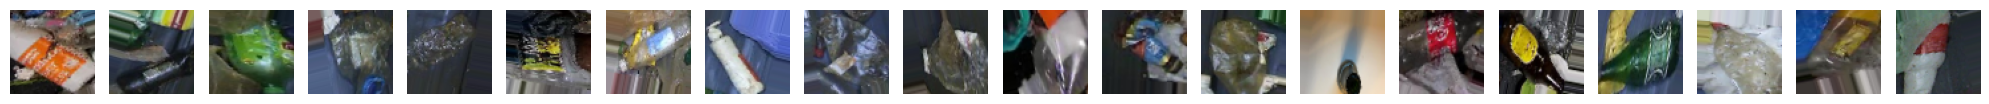

In [14]:
sample_training_images, _ = next(train_generator_full)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 20, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:20])


##Define the model

In [15]:
def build_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])

    #compile model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

##Train model

In [16]:
cnn_model = build_cnn()
history_cnn = cnn_model.fit(train_generator,
                            validation_data=validation_generator,
                            epochs=10)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 300ms/step - accuracy: 0.6944 - loss: 1.0616 - val_accuracy: 0.5714 - val_loss: 2.2909
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 92s 300ms/step - accuracy: 0.7523 - loss: 0.7519 - val_accuracy: 0.5714 - val_loss: 2.0665
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 143s 305ms/step - accuracy: 0.7511 - loss: 0.7177 - val_accuracy: 0.5714 - val_loss: 2.6983
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 139s 296ms/step - accuracy: 0.7668 - loss: 0.6843 - val_accuracy: 0.5714 - val_loss: 3.3840
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 143s 299ms/step - accuracy: 0.7634 - loss: 0.6781 - val_accuracy: 0.5714 - val_loss: 2.0424
Epoch 6/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 92s 297ms/step - accuracy: 0.7751 - loss: 0.6453 - val_accuracy: 0.5714 - val_loss: 2.5957
Epoch 7/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 91s 296ms/step - accuracy: 0.7773 - loss: 0.6268 - val_accuracy: 0.5714 - val_loss: 2.2968
Epoch 8/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 92s 301ms/step - accuracy: 0.7888 - loss: 0.5769 - 

##Evaluate the model

In [17]:
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(test_generator)
print(f'Precisión CNN: {test_acc_cnn:.4f}')


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.7958 - loss: 0.5794
Precisión CNN: 0.7929


#TRANSFER LEARNING

In [18]:
def build_transfer_learning_model():
    base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    base_model.trainable = False  # Congelar capas preentrenadas

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

##Evaluate model

In [19]:
tl_model = build_transfer_learning_model()
history_tl = tl_model.fit(train_generator, validation_data=validation_generator, epochs=10)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 518s 2s/step - accuracy: 0.7328 - loss: 0.8333 - val_accuracy: 0.1429 - val_loss: 4.1314
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - accuracy: 0.7924 - loss: 0.6082 - val_accuracy: 0.1429 - val_loss: 3.6891
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.7966 - loss: 0.5838 - val_accuracy: 0.1429 - val_loss: 5.3830
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 565s 2s/step - accuracy: 0.8048 - loss: 0.5599 - val_accuracy: 0.1429 - val_loss: 3.5729
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - accuracy: 0.8112 - loss: 0.5571 - val_accuracy: 0.1429 - val_loss: 2.3543
Epoch 6/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.8132 - loss: 0.5442 - val_accuracy: 0.1429 - val_loss: 3.3037
Epoch 7/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.8132 - loss: 0.5277 - val_accuracy: 0.1429 - val_loss: 4.7989
Epoch 8/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 517s 2

##Evaluate model

In [20]:
test_loss_tl, test_acc_tl = tl_model.evaluate(test_generator)
print(f'Precisión Transfer Learning: {test_acc_tl:.4f}')

57/57 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.7916 - loss: 0.5822
Precisión Transfer Learning: 0.7867


#SUPPORT VECTOR MACHINE

In [21]:
def extract_features(model, generator, batch_size=32):
    features = []
    labels = []
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features.append(features_batch)
        labels.append(labels_batch)
        if len(features) * batch_size >= generator.samples:
            break
    return np.vstack(features), np.vstack(labels)

##VGG16 for feature extraction

In [22]:
feature_extractor = applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

train_features, train_labels = extract_features(feature_extractor, train_generator)
test_features, test_labels = extract_features(feature_extractor, test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

##Flaten the features

In [23]:
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

##Convert labels to a format suitable for SVM

In [24]:
lb = LabelBinarizer()
train_labels = lb.fit_transform(np.argmax(train_labels, axis=1))
test_labels = lb.transform(np.argmax(test_labels, axis=1))

##Train SVM

In [25]:
svm_model = svm.SVC(kernel='linear')
svm_model.fit(train_features, np.argmax(train_labels, axis=1))

SVC(kernel='linear')

##Evaluate the SVM

In [26]:
svm_predictions = svm_model.predict(test_features)
svm_acc = accuracy_score(np.argmax(test_labels, axis=1), svm_predictions)
print(f'Precisión SVM: {svm_acc:.4f}')

Precisión SVM: 0.7439


#Comparison of the three models

In [27]:
def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(12, 8))
    for name, history in histories.items():
        plt.plot(history.history[key], label=f'{name} {key}')
        plt.plot(history.history[f'val_{key}'], label=f'{name} val_{key}')
    plt.title(f'{key.capitalize()} durante el entrenamiento y validación')
    plt.xlabel('Épocas')
    plt.ylabel(key.capitalize())
    plt.legend(loc='lower right')
    plt.show()

##Plot accuray

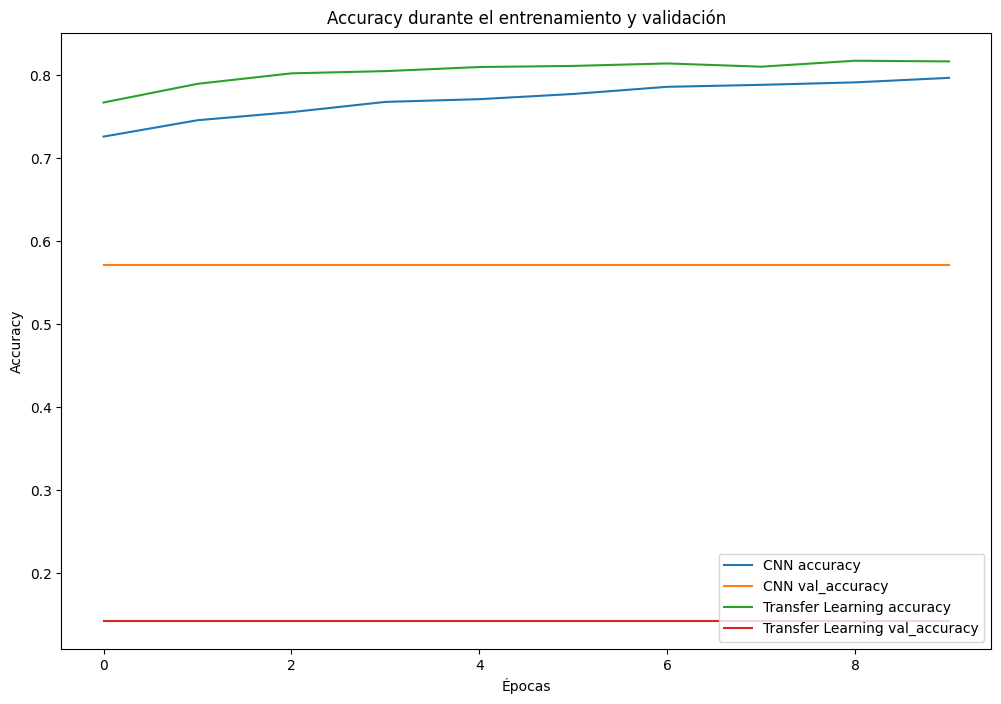

In [28]:
plot_history({
    'CNN': history_cnn,
    'Transfer Learning': history_tl,
}, key='accuracy')

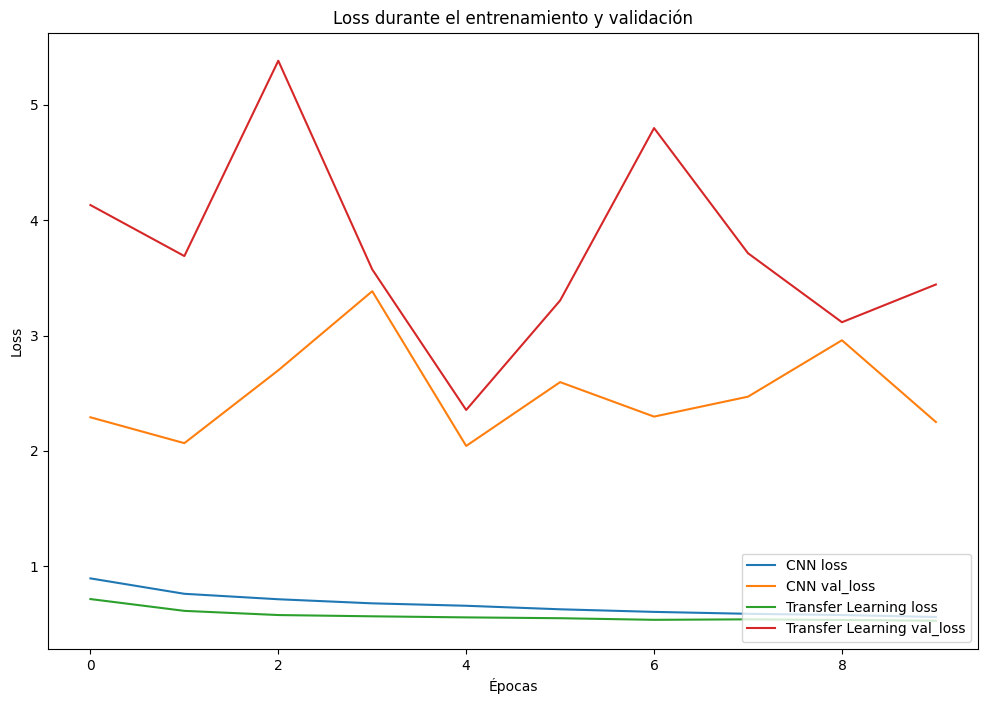

In [29]:
plot_history({
    'CNN': history_cnn,
    'Transfer Learning': history_tl,
}, key='loss')

In [30]:
print(f'Precisión CNN: {test_acc_cnn:.4f}')
print(f'Precisión Transfer Learning: {test_acc_tl:.4f}')
print(f'Precisión SVM: {svm_acc:.4f}')

Precisión CNN: 0.7929
Precisión Transfer Learning: 0.7867
Precisión SVM: 0.7439


#SUPPORT THE RESULTS

##Predicciones de los modelos

In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# CNN Predictions
y_true = test_generator.classes
y_pred_cnn = np.argmax(cnn_model.predict(test_generator), axis=1)

# Transfer Learning Predictions
y_pred_tl = np.argmax(tl_model.predict(test_generator), axis=1)

# SVM Predictions
y_pred_svm = svm_model.predict(test_features)

# Create a list of class labels
class_labels = list(test_generator.class_indices.keys())


57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step


##Confusion Matrix

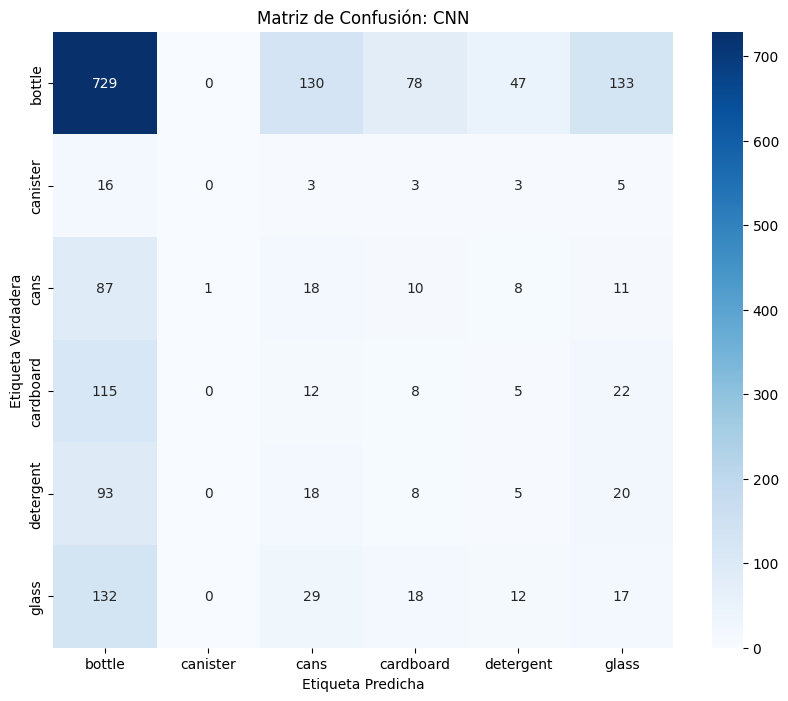

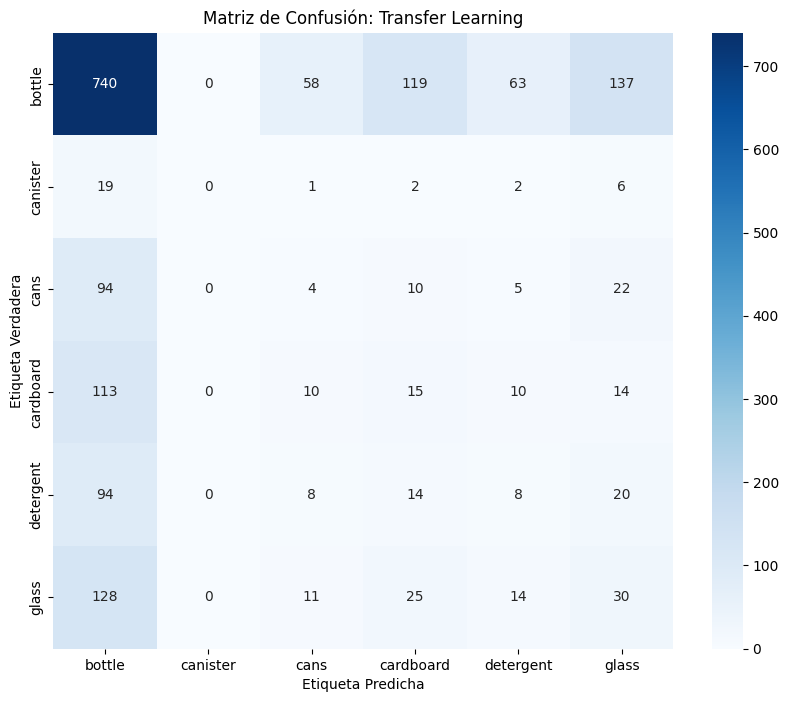

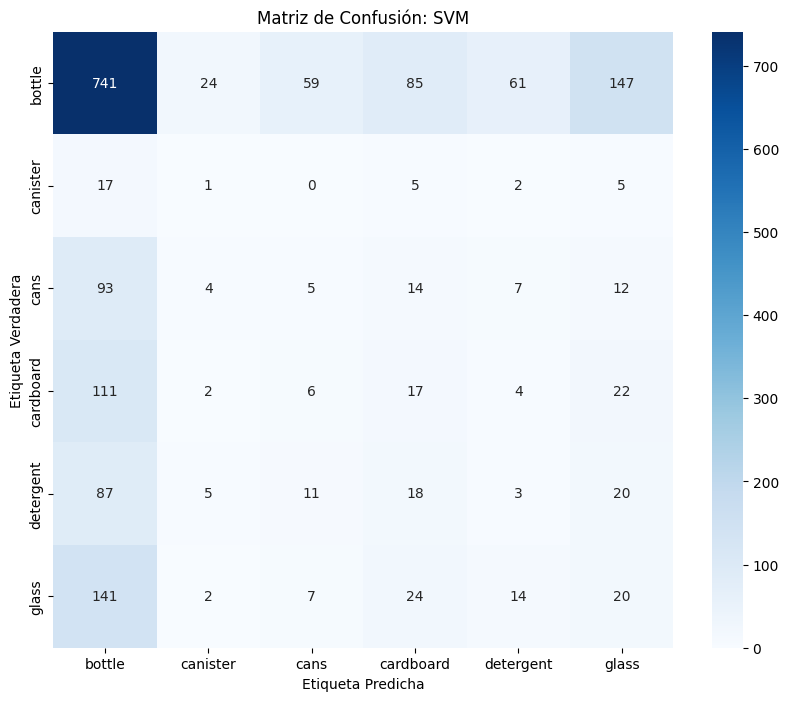

In [32]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Matriz de Confusión: {title}')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

# Confusion matrices for each algorithm
plot_confusion_matrix(y_true, y_pred_cnn, 'CNN')
plot_confusion_matrix(y_true, y_pred_tl, 'Transfer Learning')
plot_confusion_matrix(y_true, y_pred_svm, 'SVM')

##View Examples of Incorrect Predictions

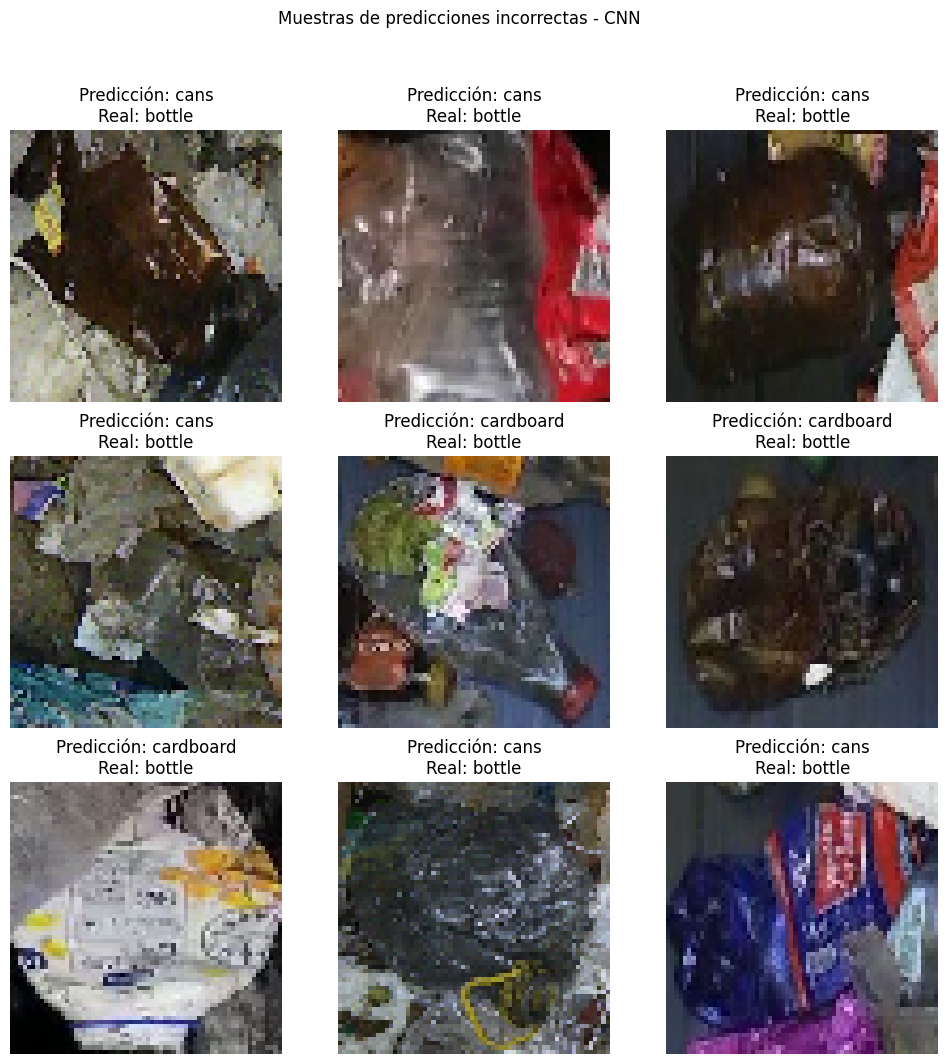

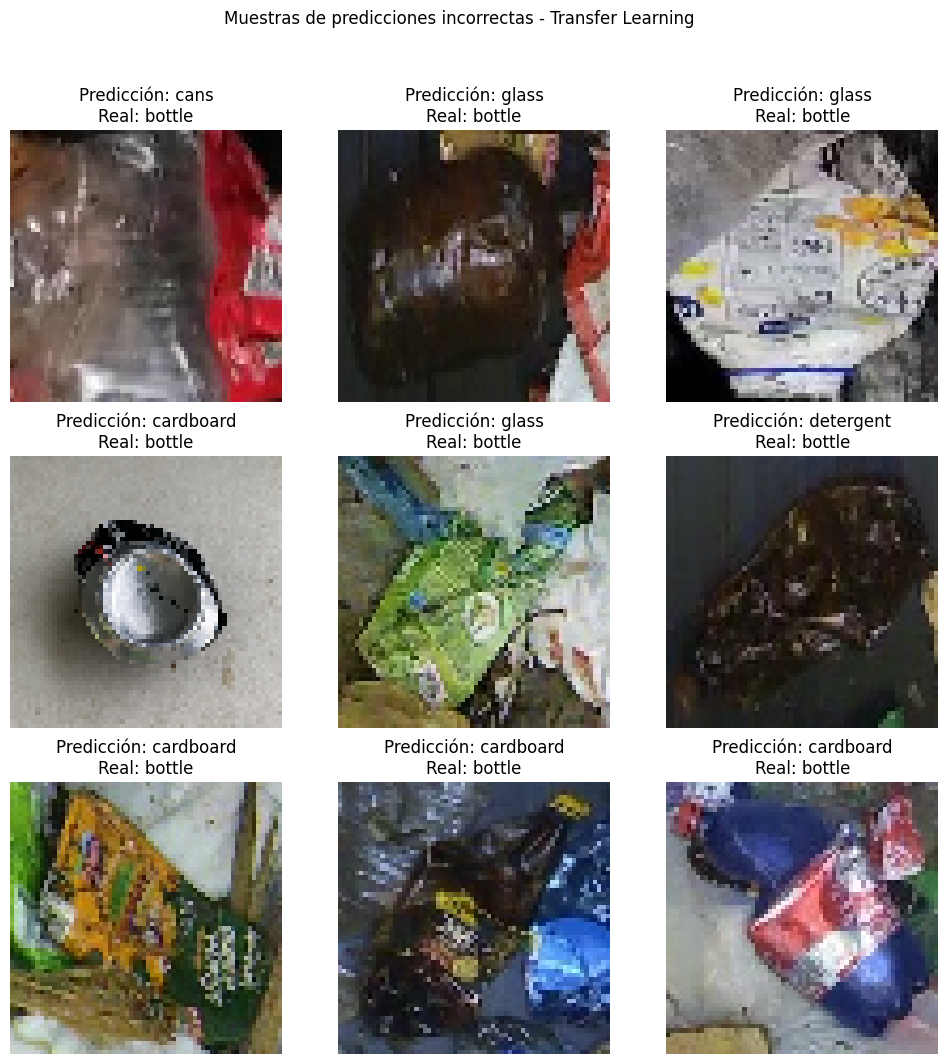

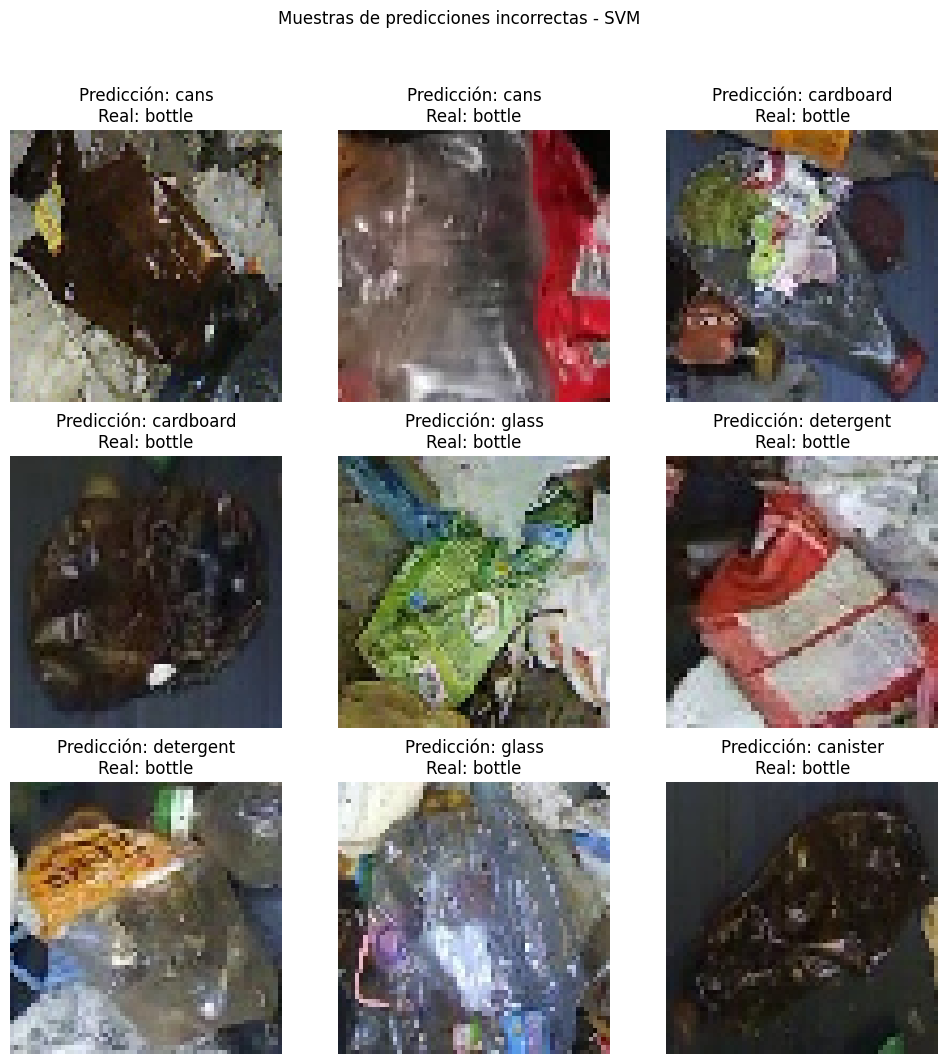

In [33]:
def plot_misclassified_images(test_generator, y_true, y_pred, title):
    misclassified_indices = np.where(y_true != y_pred)[0]

    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(misclassified_indices[:9]):  # Mostrar hasta 9 imágenes
        plt.subplot(3, 3, i + 1)
        img, label = test_generator[idx]
        plt.imshow(img[0])
        plt.title(f'Predicción: {class_labels[y_pred[idx]]}\nReal: {class_labels[y_true[idx]]}')
        plt.axis('off')
    plt.suptitle(f'Muestras de predicciones incorrectas - {title}')
    plt.show()

# Show incorrect examples for each model
plot_misclassified_images(test_generator, y_true, y_pred_cnn, 'CNN')
plot_misclassified_images(test_generator, y_true, y_pred_tl, 'Transfer Learning')
plot_misclassified_images(test_generator, y_true, y_pred_svm, 'SVM')


##Class Accuracy Charts

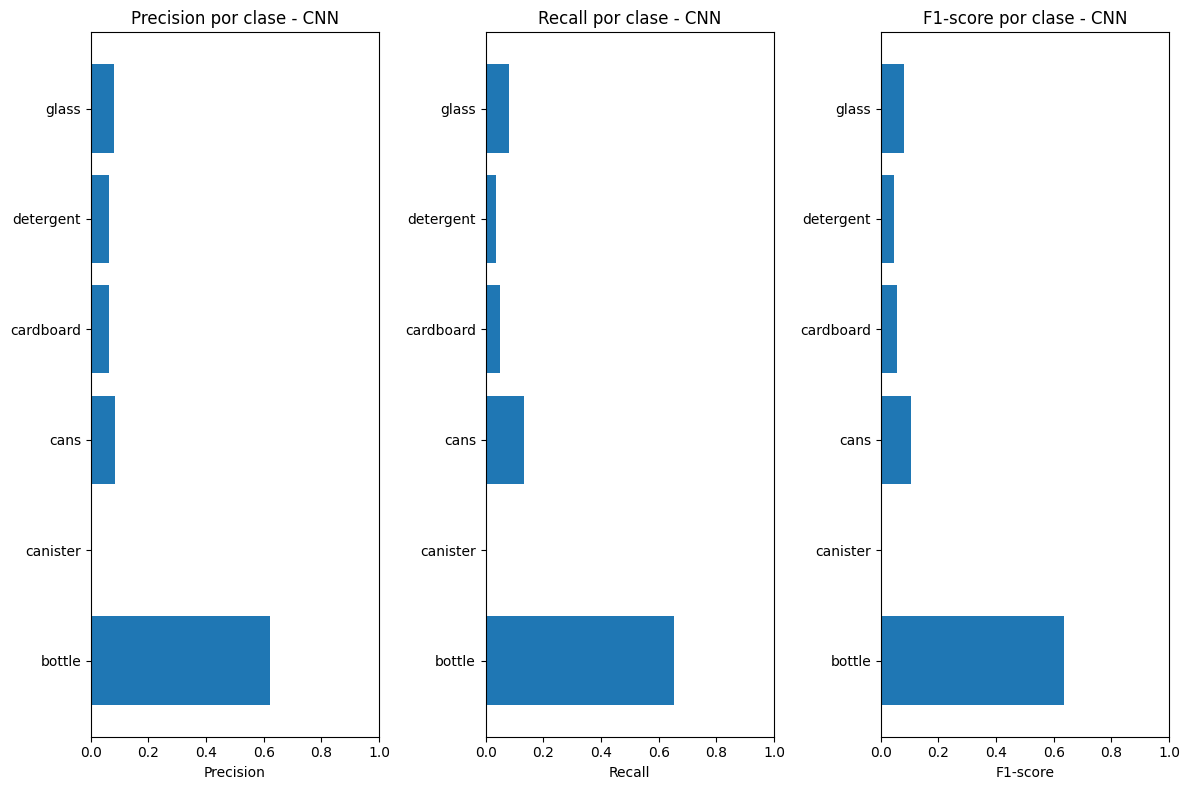

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


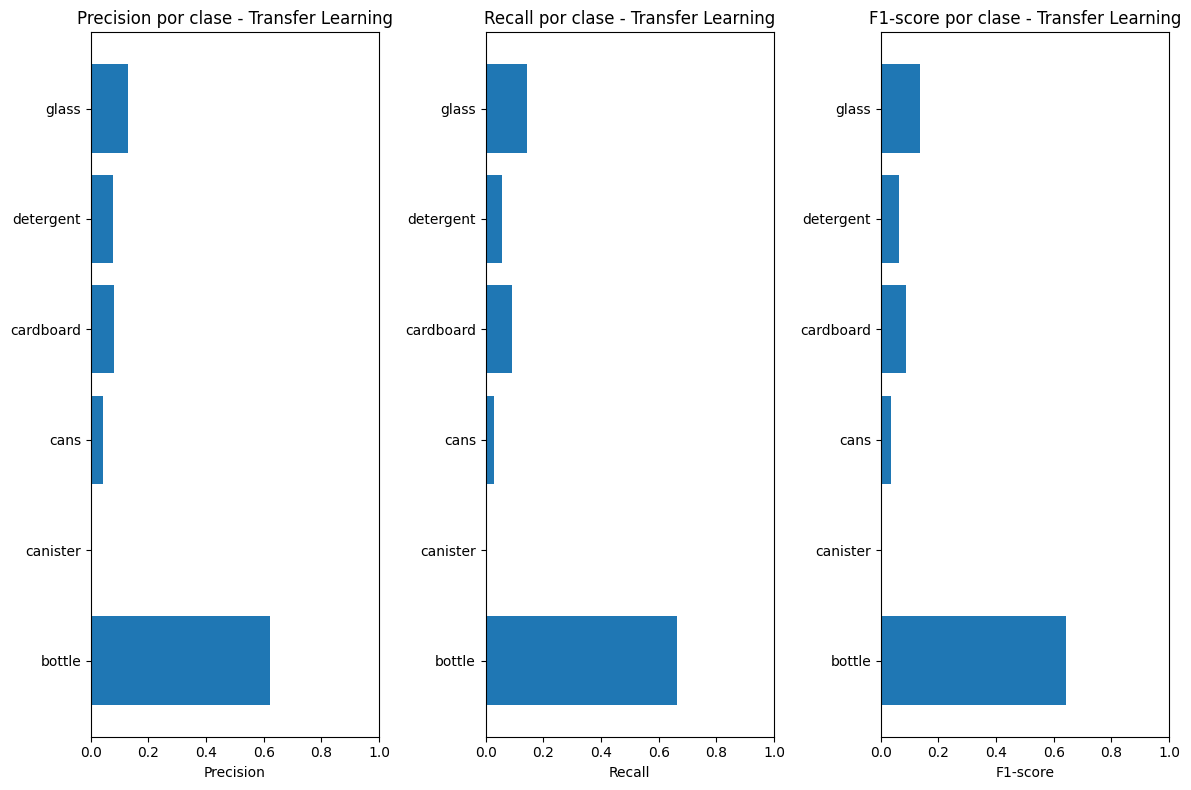

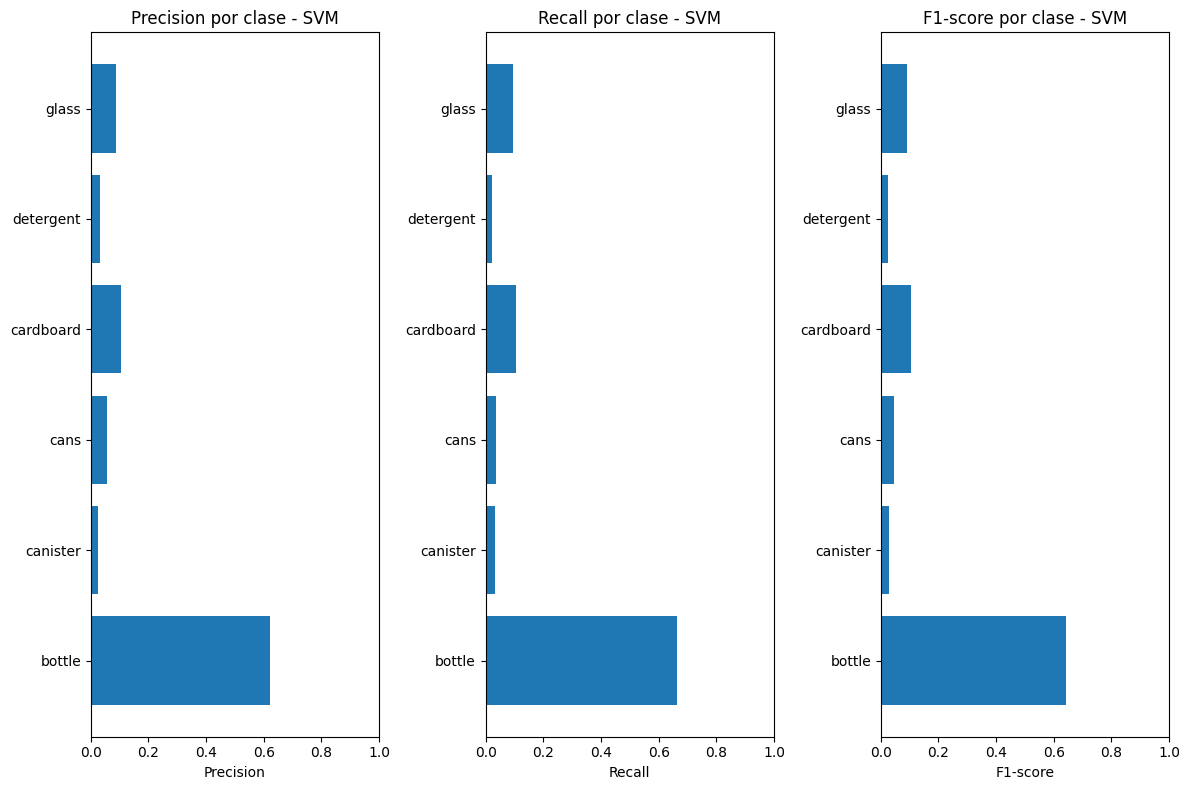

In [34]:
def plot_classification_report(y_true, y_pred, title):
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

    metrics = ['precision', 'recall', 'f1-score']
    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i + 1)
        scores = [report[label][metric] for label in class_labels]
        plt.barh(class_labels, scores)
        plt.title(f'{metric.capitalize()} por clase - {title}')
        plt.xlabel(f'{metric.capitalize()}')
        plt.xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Precision, recall, F1 graph per class for each algorithm
plot_classification_report(y_true, y_pred_cnn, 'CNN')
plot_classification_report(y_true, y_pred_tl, 'Transfer Learning')
plot_classification_report(y_true, y_pred_svm, 'SVM')
